In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_sdss_sspp
from astroML.plotting.tools import draw_ellipse

/home/brunodominguez/anaconda3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

In [3]:
N = np.arange(2, 14)

def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
BIC2 = [None for n in N]
AIC2 = [None for n in N]

for i in range(len(N)):
    BIC2[i] = -2*np.sum(models[i].score_samples(X)) + N[i]*5.5*np.log(X.size)
    AIC2[i] = -2*np.sum(models[i].score_samples(X)) + 5.5*(2*N[i] + 2*N[i]*(N[i]+1)/(X.size-N[i]-1))


i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
BIC: n_components =  5


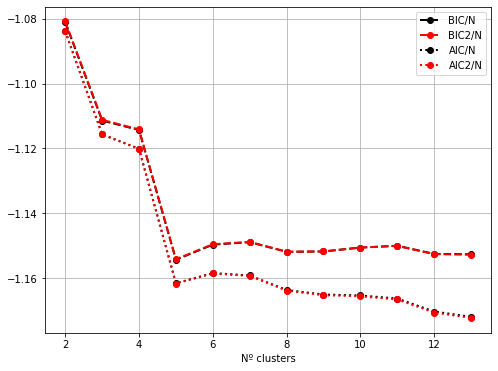

In [4]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(N, np.array(BIC)/X.size, '--k', marker='o', lw=2, ms=6, label='BIC/N')
ax.plot(N, np.array(BIC2)/X.size, '--r', marker='o', lw=2, ms=6, label='BIC2/N')
# ax.plot(N, np.array(BIC3)/X.size, '--b', marker='o', lw=2, ms=6, label='BIC3/N')
ax.plot(N, np.array(AIC)/X.size, ':k', marker='o', lw=2, ms=6, label='AIC/N')
ax.plot(N, np.array(AIC2)/X.size, ':r', marker='o', lw=2, ms=6, label='AIC2/N')
# ax.plot(N, np.array(AIC3)/X.size, '--b', marker='o', lw=2, ms=6, label='AIC3/N')
ax.legend(loc=1)
ax.set_xlabel('Nº clusters')
# ax.set_ylabel('BIC/N')
ax.grid()


In [99]:
BIC

[-32919.02253569861,
 -33850.35679406168,
 -33922.34064253089,
 -35154.157989334635,
 -35006.5225750841,
 -34987.99679936776,
 -35030.13851256311,
 -35009.80439120654,
 -35027.71291771994,
 -35016.60999062889,
 -35011.817122436914,
 -35092.4749979443]

In [58]:
BIC2 = [None for n in N]
AIC2 = [None for n in N]
for i in range(len(N)):
    BIC2[i] = -2*np.sum(models[i].score_samples(X)) + N[i]*np.log(X.size)
    AIC2[i] = -2*np.sum(models[i].score_samples(X)) + 2*N[i] + 2*N[i]*(N[i]+1)/(X.size-N[i]-1)


In [33]:
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

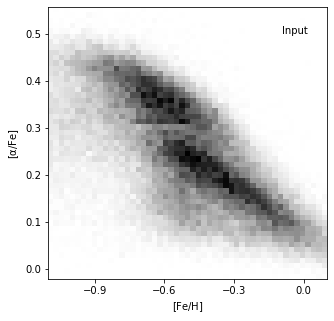

In [36]:
fig = plt.figure(figsize=(5,5))

# define plot_figure to plot all figures with the same format.
def plot_figure(number, data, text):
    ax = fig.add_subplot(number)
    ax.imshow(data,
              origin='lower', interpolation='nearest', aspect='auto',
              extent=[FeH_bins[0], FeH_bins[-1],
                      alphFe_bins[0], alphFe_bins[-1]],
              cmap=plt.cm.binary)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
    ax.set_xlabel(r'$\rm [Fe/H]$')
    ax.set_xlim(-1.101, 0.101)
    ax.text(0.93, 0.93, text,
            va='top', ha='right', transform=ax.transAxes)
    ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
    return ax

ax = plot_figure(111, H.T, "Input")
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
plt.show()

Text(0, 0.5, '$\\rm [\\alpha/Fe]$')

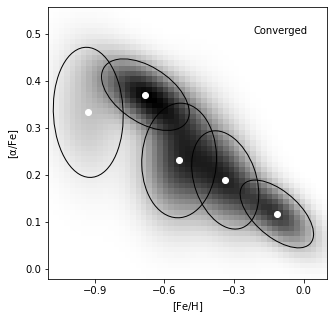

In [35]:
fig = plt.figure(figsize=(5,5))

ax = plot_figure(111, np.exp(log_dens), "Converged")

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.set_ylabel(r'$\rm [\alpha/Fe]$')

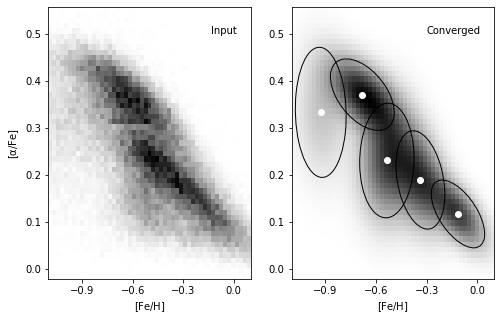

In [38]:
fig = plt.figure(figsize=(8, 5))

# plot density
ax1 = plot_figure(121, H.T, "Input")
ax1.set_ylabel(r'$\rm [\alpha/Fe]$')

ax2 = plot_figure(122, np.exp(log_dens), "Converged")
ax2.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax2, fc='none', ec='k')